In [1]:
%pip install nltk networkx
import nltk
nltk.download('wordnet')

You should consider upgrading via the '/home/mh/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package wordnet to /home/mh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from nltk.corpus import wordnet as wn
import networkx as nx

import numpy as np
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
from ipywidgets import interact

In [3]:
all_syns = list(wn.all_synsets())

d = {}
ID_dict = {}

for i,x in enumerate(all_syns):
    w = x.name()
    d[w] = i
    ID_dict[i] = w

In [4]:
n = len(all_syns)
G = nx.Graph()
G.add_nodes_from(range(n))

for i,x in enumerate(all_syns):
    for y in x.hypernyms():
        j = d[y.name()]
        G.add_edge(i,j)        

print('|V| =', len(G))
print('|E| =', G.number_of_edges())

|V| = 117659
|E| = 89089


In [5]:
cc = list(nx.connected_components(G))
cc.sort(key=len, reverse=True)
print(len(cc), 'connected compents')
print('largest:', *map(len, cc[:5]))

H = G.subgraph(cc[4])
print('|V| =', len(H))
print('|E| =', H.number_of_edges())

30043 connected compents
largest: 74374 6848 721 451 329
|V| = 329
|E| = 328


In [6]:
if max(H.nodes) > len(H):
    compress = dict(zip(H.nodes, range(len(H))))
    H = nx.relabel_nodes(H, compress)
    IDH = { i_new: ID_dict[i_old] for i_old, i_new in compress.items() }
    dH = { ID_dict[i_old]: i_new for i_old, i_new in compress.items() }

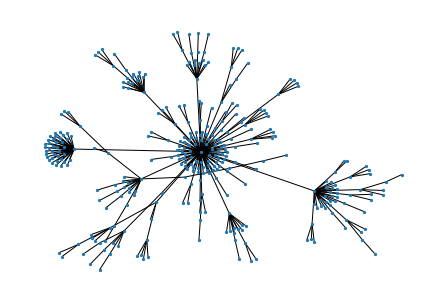

In [7]:
pos = nx.spring_layout(H)
nx.draw(H, node_size=5, pos=pos)

In [8]:
print(list(dH.keys())[:20])
wn.synset(list(dH.keys())[0]).root_hypernyms()

['kick_back.v.02', 'aerosolize.v.02', 'spread.v.02', 'catch.v.26', 'fluff_up.v.01', 'move.v.03', 'drop_back.v.01', 'hit_the_dirt.v.01', 'gravitate.v.03', 'fly.v.02', 'log_out.v.01', 'move_over.v.01', 'go.v.03', 'shove_off.v.01', 'reach.v.03', 'cut_to.v.01', 'turn_on_a_dime.v.01', 'lurch.v.02', 'jolt.v.01', 'duck.v.01']


[Synset('move.v.03')]

In [9]:
# export to AMPL
with open('graph4.dat','w') as fp:
    fp.write('data;\n')
    fp.write(f'param n := {len(H)};\n')
    fp.write('set E :=')
    for i,j in H.edges:
        fp.write(f' ({i},{j})')
    fp.write(';\nvar x :=')
    for i in H: fp.write(f' {i} {pos[i][0]}')
    fp.write(';\nvar y :=')
    for i in H: fp.write(f' {i} {pos[i][1]}')
    fp.write(';\n')

In [10]:
## run AMPL

In [11]:
res = open('res').readlines()
pts = np.array(eval(res[-1]))

In [12]:
def shift(pts, O):
    z = pts[:,0] + 1j * pts[:,1]
    k = O[0] + 1j * O[1]
    Fz = (z-k)/(1 - np.conj(k)*z)
    return np.c_[Fz.real, Fz.imag]

lH = nx.relabel_nodes(H,IDH)

In [13]:
def f(x,y):
    global p2
    
    p2 = shift(pts, (x,y))
    # p2 = { IDH[i]: p2[i] for i in range(len(H))}
    
    fig, ax = plt.subplots(figsize=(15,15))
    circle = plt.Circle((0,0),1,color='r', fill=False)
    ax.add_patch(circle)
    circle = plt.Circle((0,0),.005,color='#808080', fill=False)
    ax.add_patch(circle)
    nx.draw(H, node_size=5, pos=p2, ax=ax)
    # nx.draw(lH, node_size=5, pos=p2, axis=ax, with_labels=True)

# interact(f, x=(-1.,1.,.01), y=(-1.,1.,.01));

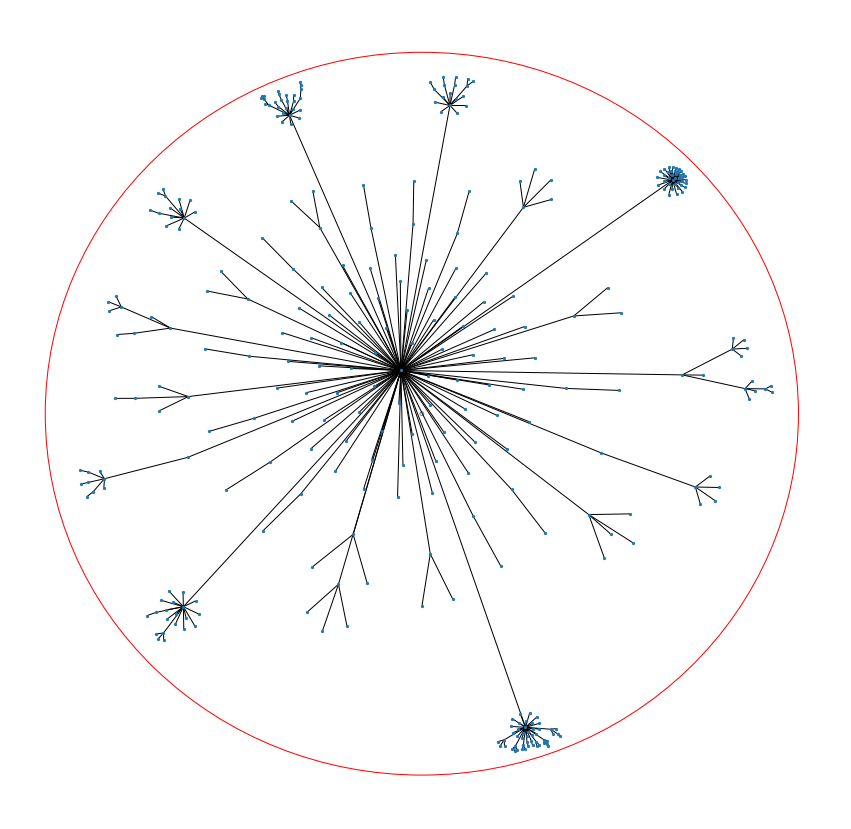

In [14]:
# interact output is lost on save
f(0,0)

In [15]:
idx = np.argsort( np.linalg.norm(p2,axis=1) )
for i in idx[:10]:
    print(IDH[i], p2[i])

teeter.v.01 [0.021781 0.02486 ]
pulsate.v.02 [-0.02576  -0.055442]
putter.v.03 [-0.061185  0.028871]
cut_to.v.01 [ 0.059193 -0.051853]
cut.v.14 [0.016117 0.105061]
jump.v.08 [0.113826 0.013488]
list.v.03 [-0.106146 -0.047287]
move.v.03 [-0.055494  0.119487]
gravitate.v.03 [0.094342 0.093155]
close.v.11 [ 0.037408 -0.132085]


In [16]:
def hyperdist(p1,p2):
    return np.arccosh(1 + 2*np.dot(p1-p2,p1-p2) \
        / ( (1-np.dot(p1,p1))*(1-np.dot(p2,p2)) ))

dist = squareform(pdist(pts, hyperdist))

MAP = 0
for u in H.nodes:
    nb = list(H.neighbors(u))
    sz = len(nb)
    
    inter = 0
    clos = np.argsort(dist[u])
    prec = 0
    for i in range(1,sz+1):
        v = clos[i]
        if v in nb: inter += 1
        prec += inter / i
    MAP += prec / sz
print(MAP / len(H))

0.28817742634732957
